# Crane optimization
*Here is some text explaining the problem at hand.*

In [1]:
# Enable interactive plot
# %matplotlib notebook
%matplotlib inline

In [2]:
# Imports:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib import animation
import casadi as cs
plt.style.use('seaborn-deep')

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png, .animation {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

*Show image of system.*

The states of the system are the position of the cart $r$ and the angle of the pendulum $\theta$, such that $x = \begin{bmatrix} r & \theta \end{bmatrix}^{\top}$.

*Explain more here.*

The dynamics of the overhead crane system can be formulated as:
$
M(x) \ddot{x} + h(x, \dot{x}) = u, 
$
where 
$
M(x) = \begin{bmatrix} m_1 + m_2 & m_2 \ell \cos(\theta) \\ m_2 \ell \cos(\theta) & m_2 \ell^2 \end{bmatrix},
\quad h(x, \dot{x}) = \begin{bmatrix} -m_2 \ell \dot{\theta}^2 \sin{\theta} \\ m_2 \ell g \sin{\theta} \end{bmatrix},
\quad u = \begin{bmatrix} F \\ 0 \end{bmatrix}
$
and $F$ is the force we push the "cart" with. By optimizing $F$ over time we can achieve our desired motion.

We write down the dynamics symbolically using CasADi:

In [4]:
r = cs.MX.sym('r')
theta = cs.MX.sym('theta')
r_dot = cs.MX.sym('r_dot')
theta_dot = cs.MX.sym('theta_dot')
x = cs.vertcat(r, theta, r_dot, theta_dot)

u = cs.MX.sym('F')

m_1 = 5.0  # mass of cart
m_2 = 1.0  # mass of pendulum
l = 1.0    # length of pendulum
g = 9.81   # gravity

M_inv = cs.MX(2,2)
M_inv[0,0] = m_2 * l**2
M_inv[0,1] = - m_2 * l * cs.cos(theta)
M_inv[1,0] = - m_2 * l * cs.cos(theta)
M_inv[1,1] = m_1 + m_2
M_inv = M_inv / ((m_1 + m_2) * m_2 * l**2 - m_2**2 * l**2 * cs.cos(theta)**2)

h = cs.MX(2,1)
h[0,0] = -m_2 * l * theta_dot**2 * cs.sin(theta)
h[1,0] = m_2 * l * g * cs.sin(theta)

x_dot = cs.vertcat(x[2:], cs.mtimes(M_inv, (cs.vertcat(u, 0) - h)))
f = cs.Function('f', [x, u], [x_dot])

The dynamics described above are however continuous. We want to discretize the problem into steps of length $\Delta T$, such that we have a finite number of optimization variables:
$
\ddot{x} = f(x, \dot{x}, u) \quad \rightarrow \quad \dot{x}_{k+1} = f_d(x_k, \dot{x}_k, u_k)
$
Without going into further detail on discretization methods, we apply the much used Runge Kutta 4 (RK4) method in order to get $f_d$:

In [5]:
def integrate_RK4(x_k, u_k, f, dt):
    k1 = f(x_k, u_k)
    k2 = f(x_k + dt * k1 / 2.0, u_k)
    k3 = f(x_k + dt * k2 / 2.0, u_k)
    k4 = f(x_k + dt * k3, u_k)
    return x_k + (dt / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)

dt = 0.05
x_0 = np.array([-0.5, 0.0, 0.0, 0.0])

f_d = cs.Function('f', [x, u], [integrate_RK4(x, u, f, dt)])

*Need to show problem we are formulating and explain NLPs briefly*

\begin{aligned}
    \min_{u} \quad & \sum_{i=0}^{N-1}{R_r (r_i - r_0)^2 + R_\theta \theta^2} + R_{\dot{r}} \dot{r}^2 + R_{\dot{\theta}} \dot{\theta}^2 \\
    \textrm{s.t.} \quad & x_{k+1} = f_d(x_k, u_k) \quad \forall k = 0, 1, \dots, N-1 \\
    & x_0 = x(k)    \\
\end{aligned}

In [6]:
# Number of control segments
N = 80

r_0 = 0.5

def optimize_crane(N, x_0, r_0, use_u_cost=False, use_term_constraint=False, use_u_constraint=False, u_max=None, use_theta_constraint=False, theta_max=None):
    R_r = 100
    R_theta = 100
    R_r_dot = 1
    R_theta_dot = 1
    R_u = 0.1 if use_u_cost else 0

    # Objective function and constraints
    J_k = cs.Function('J_k', [x, u], [R_r*(x[0] - r_0)**2 + R_theta*x[1]**2 + R_r_dot*x[2]**2 + R_theta_dot*x[3]**2 + R_u*u**2])

    # Start with an empty NLP
    w = []
    w0 = [] # TODO set one single time instead
    lbw = []
    ubw = []
    J = 0
    g = []
    lbg = []
    ubg = []

    # Formulate the NLP
    X_k = cs.MX(x_0)
    for k in range(N):
        # Control variable at step k:
        U_k = cs.MX.sym('U_' + str(k))
        w += [U_k]
        w0 += [0]
        
        if use_u_constraint:
            lbw += [-u_max]
            ubw += [u_max]
        else:
            lbw += [-cs.inf]
            ubw += [cs.inf]

        # Integrate till the end of the interval:
        X_k = f_d(X_k, U_k)
        J += dt * J_k(X_k, U_k)

        if use_theta_constraint:
            g += [X_k[1]]
            lbg += [-theta_max]
            ubg += [theta_max]

    if use_term_constraint:
        g += [X_k[0] - r_0]
        lbg += [0.0]
        ubg += [0.0]

        g += [X_k[1:]]
        lbg += [0.0, 0.0, 0.0]
        ubg += [0.0, 0.0, 0.0]

    # Create an NLP solver
    nlp = {'f': J, 'x': cs.vertcat(*w), 'g': cs.vertcat(*g)}
    opts = {'ipopt.print_level':0, 'print_time':0}
    solver = cs.nlpsol('solver', 'ipopt', nlp, opts)

    # Solve the NLP
    sol = solver(x0=w0, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)
    u_sol = sol['x']

    return u_sol

We simulate the system with the input we calculated:

In [7]:
N_sim = 1000
dt_sim = 0.005

def simulate_crane(x_0, u):
    k_u = int(dt/dt_sim)
    x_sim = np.zeros((N_sim+1,4))
    x_sim[0,:] = x_0
    u_sim = np.zeros(N_sim)
    for k in range(N_sim):
        if k < k_u * N: u_sim[k] = u[int(k/k_u)]
        x_sim[k+1] = np.array(integrate_RK4(x_sim[k], u_sim[k], f, dt_sim)).squeeze()
    return x_sim, u_sim

Here is some code for plotting the simulation results:

In [76]:
mpl.rcParams['lines.linewidth'] = 2

def plot_results(x_sim, u_sim):
    t = np.array([dt_sim*i for i in range(N_sim)])
    
    fig, ax = plt.subplots(figsize=(8,4))
    ax.step(t, u_sim, where='post', c='mediumblue')
    ax.set_title('Control input')
    ax.set_xlabel(r'$t$ (s)')
    ax.set_ylabel(r'$F$ (N)')

    fig, ax = plt.subplots(2,2, figsize=(10,5))

    ax[0,0].plot([0, np.max(t)], r_0 * np.ones(2), '--', c='crimson')
    ax[0,0].plot(t, x_sim[:N_sim,0], c='mediumblue', alpha=0.7)
    ax[0,0].set_ylabel(r'$x$ (m)')
    ax[0,0].set_xlabel(r'$t$ (s)')
    
    ax[0,1].plot([0, np.max(t)], np.zeros(2), '--', c='crimson')
    ax[0,1].plot(t, x_sim[:N_sim,1], c='mediumblue', alpha=0.7)
    ax[0,1].set_ylabel(r'$\theta$ (rad)')
    ax[0,1].set_xlabel(r'$t$ (s)')

    ax[1,0].plot([0, np.max(t)], np.zeros(2), '--', c='crimson')
    ax[1,0].plot(t, x_sim[:N_sim,2], c='mediumblue', alpha=0.7)
    ax[1,0].set_ylabel(r'$\dot{x}$ (m/s)')
    ax[1,0].set_xlabel(r'$t$ (s)')
    
    ax[1,1].plot([0, np.max(t)], np.zeros(2), '--', c='crimson')
    ax[1,1].plot(t, x_sim[:N_sim,3], c='mediumblue', alpha=0.7)
    ax[1,1].set_ylabel(r'$\dot{\theta}$ (rad/s)')
    ax[1,1].set_xlabel(r'$t$ (s)')

    plt.show()

Here is some code for animating the simulation:

In [93]:
from IPython.display import HTML

def show_animation():
    skips = 10
    frames = int(N_sim / skips)
    delay = skips*dt_sim*1e3

    rect_height = 0.15
    beam_height = 0.05
    radius = 750

    fig, ax = plt.subplots(figsize=(8,5))

    line_1, = ax.plot([-1.2,1.2], [0,0], 'k--', alpha=0.7, lw=1.5)
    rect_1 = ax.add_patch(Rectangle((0 - 1, 0 - 0.5*beam_height), 2, beam_height, facecolor='firebrick', edgecolor='k', lw=2))
    rect_2 = ax.add_patch(Rectangle((x_sim[0,0] - 0.2, 0.0 - 0.5*rect_height), 0.4, rect_height, facecolor='indianred', edgecolor='k', lw=2))

    x_pendulum = x_sim[0,0] + l * np.sin(x_sim[0,1])
    y_pendulum = -l * np.cos(x_sim[0,1])
    line_2, = ax.plot([x_sim[0,0], x_pendulum], [0, y_pendulum], '-o', c='k', lw=3, ms=6)
    point_1 = ax.scatter(x_pendulum, y_pendulum, s=radius, facecolors='darkorange', edgecolors='k', lw=2)

    line_3, = ax.plot([-0.5, -0.5], [-1,0], 'k--', alpha=0.7, lw=1.5)
    line_4, = ax.plot([0.5, 0.5], [-1,0], 'k--', alpha=0.7, lw=1.5)

    plt.axis('equal')
    plt.xlim([-1, 1])
    plt.ylim([-1.35, 0.35])

    def animate(i):
        rect_2.set_xy([x_sim[skips*i,0] - 0.2, 0.0 - 0.5*rect_height])
        
        x_pendulum = x_sim[skips*i,0] + l * np.sin(x_sim[skips*i,1])
        y_pendulum = -l * np.cos(x_sim[skips*i,1])
        
        point_1.set_offsets([x_pendulum, y_pendulum])
        line_2.set_data([x_sim[skips*i,0], x_pendulum], [0, y_pendulum])
        
        return line_2, point_1, rect_2

    return animation.FuncAnimation(fig, animate, frames=frames, interval=delay, blit=True)

Now we plot and animate the results from our first test where we only penalize the state:

*Here we could also do tuning... Not just give them the answers...*

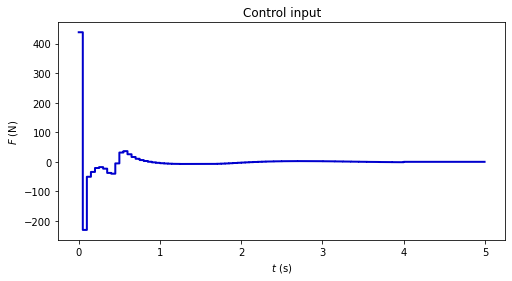

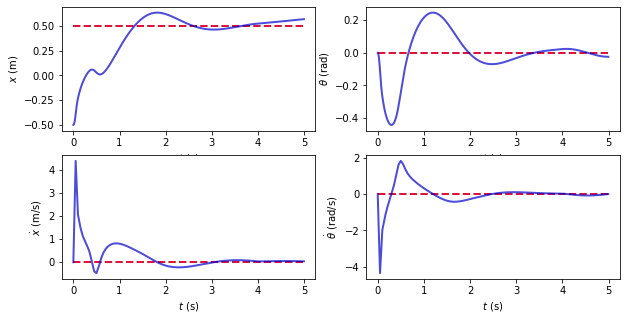

In [77]:
u_sol = optimize_crane(N, x_0, r_0)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)

Run the next cell to display the crane animation (it takes a few seconds):

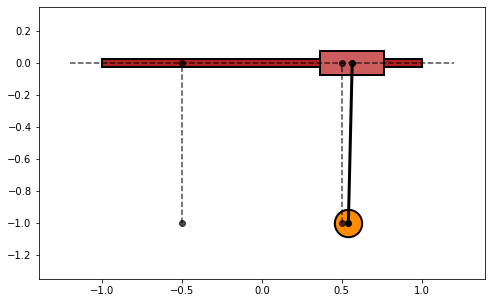

In [94]:
HTML(show_animation().to_jshtml())

We see that the control input is very high and the resulting motion is jerky and not suited for a crane...
We therefore add a penalty to large control inputs:

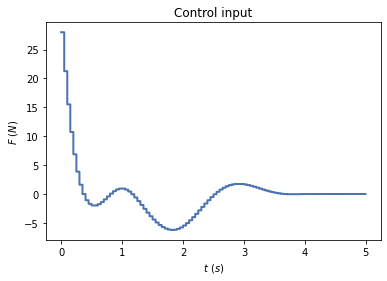

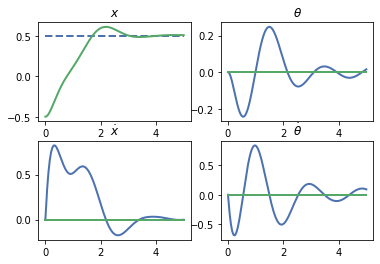

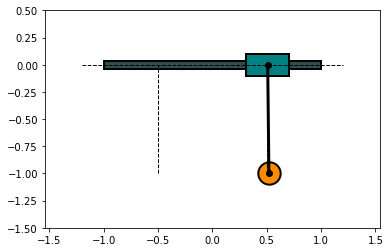

In [12]:
u_sol = optimize_crane(N, x_0, r_0, use_u_cost=True)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

That looks much smoother. But it doesnt hit our target exactly, it continues to wiggle...
We add a terminal constraint:

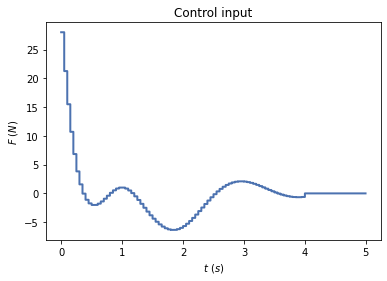

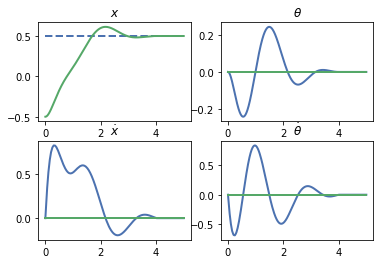

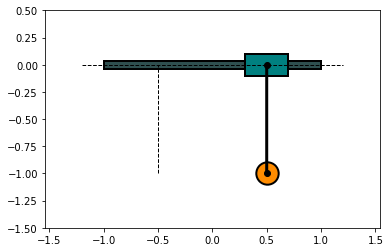

In [13]:
u_sol = optimize_crane(N, x_0, r_0, use_u_cost=True, use_term_constraint=True)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

Now we are getting somewhere! 
Ok, but what if we have a maximum force we can push the cart with? One of the main reasons why optimization is so popular in robotics applications is that such constraints can be seamlessly added to the optimization problem!

We add input constraint such that we can not push with more than say 3 N of force:

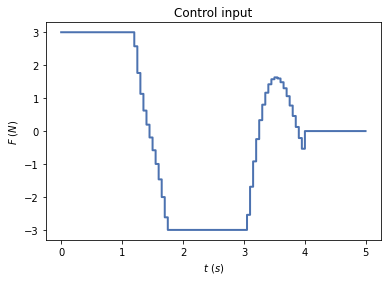

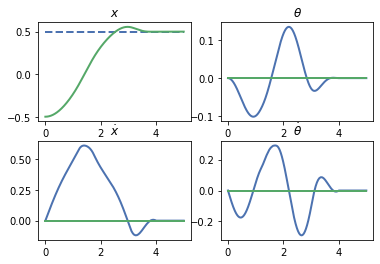

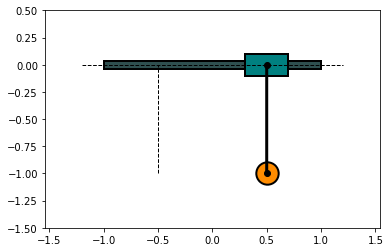

In [14]:
u_max = 3.0
u_sol = optimize_crane(N, x_0, r_0, use_u_cost=True, use_term_constraint=True, use_u_constraint=True, u_max=u_max)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

As we see from the plot of the control input we do not violate the +- 3N constraint, very nice.

Now you may ask, can we do the same with the state variables? Yes, we can! What if we want to limit the angle $\theta$ to be below e.g. 0.05?

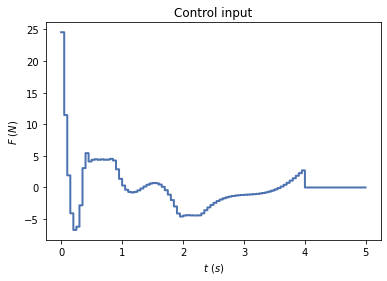

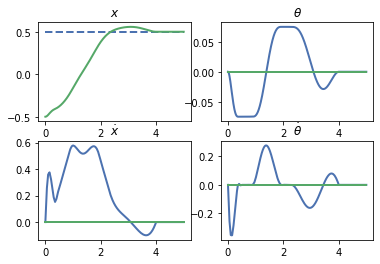

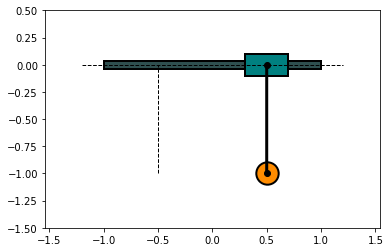

In [15]:
theta_max = 0.075
u_sol = optimize_crane(N, x_0, r_0, use_u_cost=True, use_term_constraint=True, use_theta_constraint=True, theta_max=theta_max)
x_sim, u_sim = simulate_crane(x_0, u_sol)
plot_results(x_sim, u_sim)
HTML(show_animation().to_jshtml())

Nice!

From here there is also more to explore, like more complex constraints or trajectory tracking...